# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

### Install packages

In [2]:
!pip install --quiet kaggle
!pip install --quiet -U pip
!pip install --quiet -U setuptools wheel
!pip install --quiet -U "mxnet<2.0.0" bokeh==2.0.1
!pip install --quiet autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "search4soumya"
kaggle_key = "REMOVED_(TO_BE_FILLED_DURING_EXECUTION)"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [5]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import pandas as pd
import numpy as np
from datetime import datetime

from autogluon.tabular import TabularPredictor
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns 

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv')
train.loc[:, 'datetime'] = pd.to_datetime(train.loc[:, 'datetime'])

#train['year'] = pd.to_datetime(train.loc[:,"datetime"]).dt.year
#train['month']= pd.to_datetime(train.loc[:,"datetime"]).dt.month
#train['date']= pd.to_datetime(train.loc[:,"datetime"]).dt.day
#train['hour']= pd.to_datetime(train.loc[:,"datetime"]).dt.hour
#train = train.drop(["datetime"], axis = 1)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
# find the datatype for each of the attribute 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [9]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [10]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv')
test.loc[:, 'datetime'] = pd.to_datetime(test.loc[:, 'datetime'])

#test['year'] = pd.to_datetime(test.loc[:,"datetime"]).dt.year
#test['month']= pd.to_datetime(test.loc[:,"datetime"]).dt.month
#test['date']= pd.to_datetime(test.loc[:,"datetime"]).dt.day
#test['hour']= pd.to_datetime(test.loc[:,"datetime"]).dt.hour
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
# Same thing as train and test dataset
submission =  pd.read_csv('sampleSubmission.csv')
submission.loc[:, 'datetime'] = pd.to_datetime(submission.loc[:, 'datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [12]:
train_updated= train.drop(['casual', 'registered'], axis = 1)
predictor = TabularPredictor(
    label="count", problem_type="regression", eval_metric="root_mean_squared_error"
).fit(
    train_data = train_updated,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220406_160327/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220406_160327/"
AutoGluon Version:  0.4.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3048.7 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFe

### Review AutoGluon's training run with ranking of models that did the best.

<AxesSubplot:xlabel='model'>

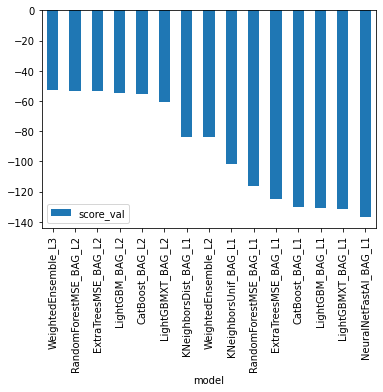

In [13]:
predictor.leaderboard(silent=True).plot(kind='bar', x = 'model', y = 'score_val')

In [14]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.756529      11.611183  507.796664                0.001110           0.741333            3       True         15
1   RandomForestMSE_BAG_L2  -53.462706      10.822655  407.649460                0.495978          25.347389            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.639497      10.823570  389.448018                0.496892           7.145947            2       True         14
3          LightGBM_BAG_L2  -55.021714      10.544282  404.269243                0.217604          21.967172            2       True         11
4          CatBoost_BAG_L2  -55.451555      10.399599  452.594824                0.072921          70.292753            2       True         13
5        LightGBMXT_BAG_L2  -60.410028      13.773225  434.147228         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -

### Create predictions from test dataset

In [15]:
#test_updated = test.drop(["datetime"], axis = 1)
#predictions = predictor.predict(test_updated)
predictions = predictor.predict(test)
predictions.head()

0    23.763222
1    41.620018
2    45.855522
3    48.996994
4    52.138283
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [16]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.793816
std        90.438499
min         2.949378
25%        20.383324
50%        62.819935
75%       170.242981
max       363.760651
Name: count, dtype: float64

In [17]:
# print(len(predictions))
#for items in predictions.iteritems():
#    print(items)

In [18]:
# How many negative values do we have?
predictions.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [19]:
# Set them to zero
predictions.iloc[predictions<0] = 0
predictions.lt(0).value_counts()

False    6493
Name: count, dtype: int64

### Set predictions to submission dataframe, save, and submit

In [20]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [21]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 421kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [22]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2022-04-06 16:14:59  first raw submission               complete  1.80645      1.80645       
submission_new_hpo.csv       2022-04-06 15:17:31  new features with hyperparameters  complete  0.47248      0.47248       
submission_new_features.csv  2022-04-06 14:57:16  new features                       complete  0.47063      0.47063       
submission.csv               2022-04-06 14:18:58  first raw submission               complete  1.80371      1.80371       


#### Initial score of `1.806`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

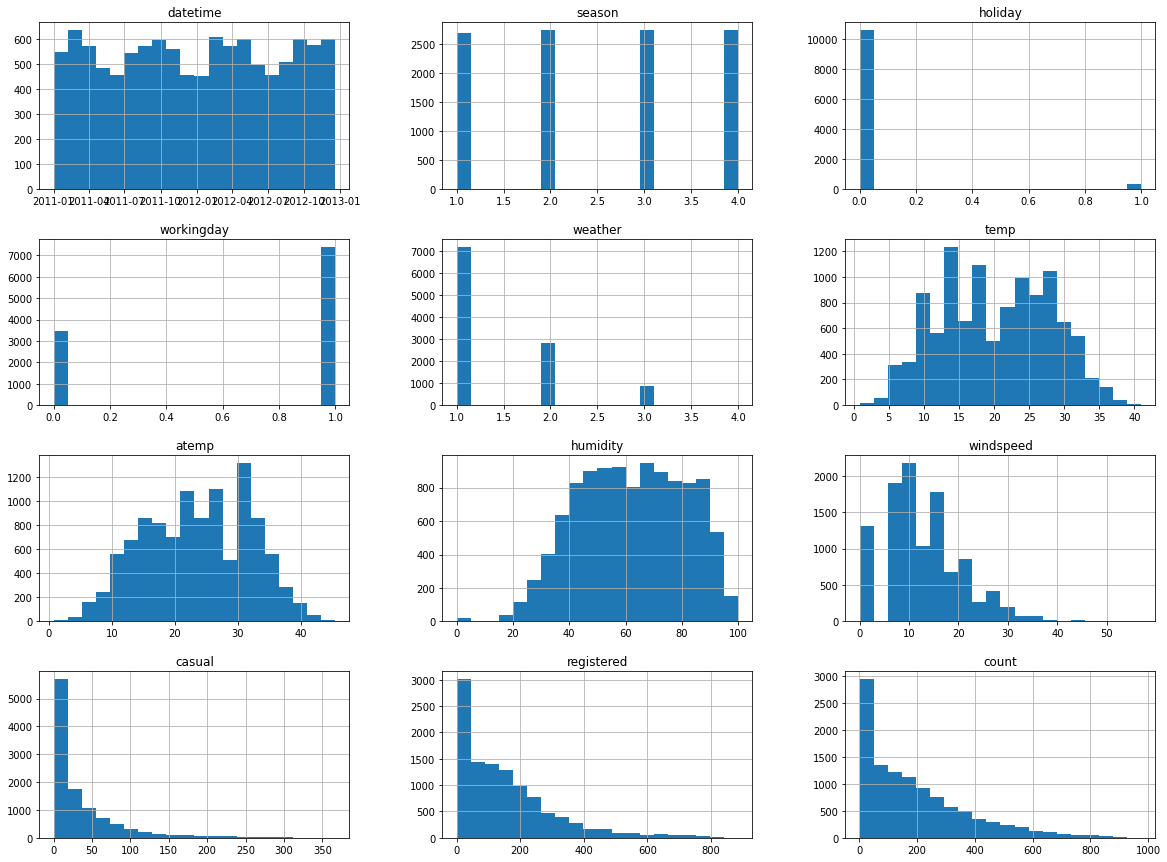

In [23]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(bins=20,figsize=(20,15))
plt.show()

In [24]:
# create a new feature from train
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train.drop(['datetime'], axis=1, inplace=True)
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [25]:
# create a new feature from test
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test.drop(['datetime'], axis=1, inplace=True)
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [26]:
train['season'] = train['season'].astype('category')
train['weather'] = train['weather'].astype('category')
test['season'] = test['season'].astype('category')
test['weather'] = test['weather'].astype('category')

# Convert the year/ month / day / hour to category
train['year'] = train['year'].astype('category')
train['month'] = train['month'].astype('category')
train['day'] = train['day'].astype('category')
train['hour'] = train['day'].astype('category')
test['year'] = test['year'].astype('category')
test['month'] = test['month'].astype('category')
test['day'] = test['day'].astype('category')
test['hour'] = test['day'].astype('category')

In [27]:
#Inspect the datatype 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  year        10886 non-null  category
 12  month       10886 non-null  category
 13  day         10886 non-null  category
 14  hour        10886 non-null  category
dtypes: category(6), float64(3), int64(6)
memory usage: 831.6 KB


In [28]:
#Inspect the datatype 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      6493 non-null   category
 1   holiday     6493 non-null   int64   
 2   workingday  6493 non-null   int64   
 3   weather     6493 non-null   category
 4   temp        6493 non-null   float64 
 5   atemp       6493 non-null   float64 
 6   humidity    6493 non-null   int64   
 7   windspeed   6493 non-null   float64 
 8   year        6493 non-null   category
 9   month       6493 non-null   category
 10  day         6493 non-null   category
 11  hour        6493 non-null   category
dtypes: category(6), float64(3), int64(3)
memory usage: 344.2 KB


In [29]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,1
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,1
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,1
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,1


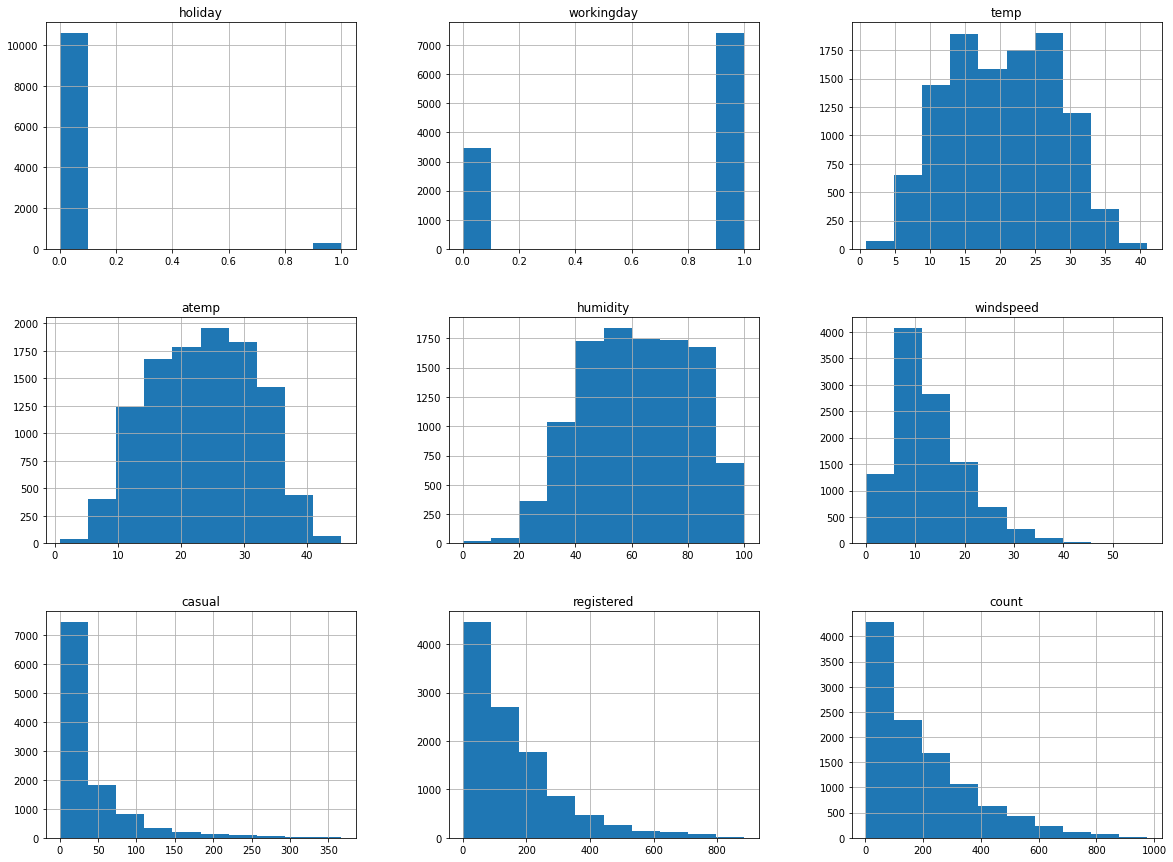

In [30]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(20,15))
plt.show()

## Step 5: Rerun the model with the same settings as before, just with more features

In [31]:
train_updated= train.drop(['casual', 'registered'], axis = 1)
predictor_new_features = TabularPredictor(
    label="count", problem_type="regression", eval_metric="root_mean_squared_error"
).fit(
    train_data = train_updated,
    time_limit=600,
    presets="best_quality"
)


No path specified. Models will be saved in: "AutogluonModels/ag-20220406_161831/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220406_161831/"
AutoGluon Version:  0.4.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2116.69 MB
	Train Data (Original)  Memory Usage: 0.59 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting Identity

<AxesSubplot:xlabel='model'>

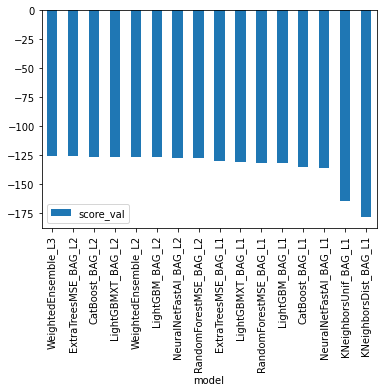

In [32]:
predictor_new_features.leaderboard(silent=True).plot(kind='bar', x = 'model', y = 'score_val')

In [33]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -125.549249      12.579924  578.095041                0.001142           0.618263            3       True         16
1     ExtraTreesMSE_BAG_L2 -126.224376      10.963675  399.734051                0.509020           7.064251            2       True         14
2          CatBoost_BAG_L2 -126.341428      10.625166  470.496004                0.170511          77.826205            2       True         13
3        LightGBMXT_BAG_L2 -126.882963      10.638863  412.154849                0.184208          19.485049            2       True         10
4      WeightedEnsemble_L2 -127.002890       8.667664  368.182854                0.000834           1.000991            2       True          9
5          LightGBM_BAG_L2 -127.027322      10.609968  413.177339         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -164.55761532708044,
  'KNeighborsDist_BAG_L1': -179.0093022915555

In [34]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.iloc[predictions_new_features<0] = 0
predictions_new_features.head()

0    81.573090
1    74.948402
2    74.948402
3    80.359009
4    80.359009
Name: count, dtype: float32

In [35]:
# Same submitting predictions
submission_new_features = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [36]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 403kB/s]
Successfully submitted to Bike Sharing Demand

In [37]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2022-04-06 16:29:22  new features                       complete  1.31956      1.31956       
submission.csv               2022-04-06 16:14:59  first raw submission               complete  1.80645      1.80645       
submission_new_hpo.csv       2022-04-06 15:17:31  new features with hyperparameters  complete  0.47248      0.47248       
submission_new_features.csv  2022-04-06 14:57:16  new features                       complete  0.47063      0.47063       


#### New Score of `1.319`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [38]:
train_updated= train.drop(['casual', 'registered'], axis = 1)
predictor_new_hpo = TabularPredictor(
    label='count', problem_type='regression', eval_metric='root_mean_squared_error'
).fit(
    train_data = train_updated,
    time_limit=600,
    num_bag_folds=5,
    num_bag_sets=1,
    num_stack_levels=1,
    presets='best_quality'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220406_163254/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220406_163254/"
AutoGluon Version:  0.4.0
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2180.95 MB
	Train Data (Original)  Memory Usage: 0.59 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting Identity

<AxesSubplot:xlabel='model'>

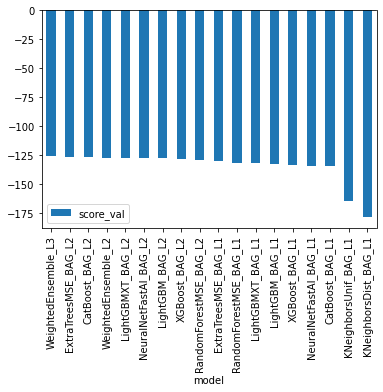

In [39]:
predictor_new_hpo.leaderboard(silent=True).plot(kind='bar', x = 'model', y = 'score_val')

In [40]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -126.024454       7.287316  506.642303                0.000840           0.577709            3       True         18
1     ExtraTreesMSE_BAG_L2 -126.758064       6.592508  390.742841                0.512512           7.531238            2       True         15
2          CatBoost_BAG_L2 -126.929862       6.222085  429.224041                0.142090          46.012437            2       True         14
3      WeightedEnsemble_L2 -127.416046       4.472858  357.513214                0.001343           0.714263            2       True         10
4        LightGBMXT_BAG_L2 -127.495030       6.235814  395.314057                0.155818          12.102453            2       True         11
5   NeuralNetFastAI_BAG_L2 -127.593820       6.533052  441.482420         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_pe

In [41]:
# Remember to set all negative values to zero
predictor_new_hpo = predictor_new_hpo.predict(test)
predictor_new_hpo.iloc[predictor_new_hpo<0] = 0
predictor_new_hpo.head()

0    86.789070
1    65.932465
2    65.932465
3    77.006897
4    77.006897
Name: count, dtype: float32

In [42]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_new_hpo["count"] = predictor_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [43]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 377kB/s]
Successfully submitted to Bike Sharing Demand

In [44]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-04-06 16:43:16  new features with hyperparameters  complete  1.33246      1.33246       
submission_new_features.csv  2022-04-06 16:29:22  new features                       complete  1.31956      1.31956       
submission.csv               2022-04-06 16:14:59  first raw submission               complete  1.80645      1.80645       
submission_new_hpo.csv       2022-04-06 15:17:31  new features with hyperparameters  complete  0.47248      0.47248       


#### New Score of `1.332`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

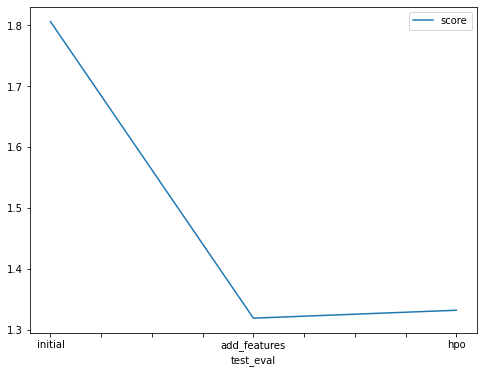

In [46]:
# Take the 3 kaggle scores and creating a line plot to show improvement (Test)
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.806, 1.319, 1.332]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('img/model_test_score.png')

### Hyperparameter table

In [47]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "num_bag_folds": [0, 0, 5],
    "num_bag_sets": [20, 20, 1],
    "num_stack_levels": [0, 0, 1],
    "score": [1.806, 1.319, 1.332]
})

,model,num_bag_folds,num_bag_sets,num_stack_levels,score
0,initial,0,20,0,1.806
1,add_features,0,20,0,1.319
2,hpo,5,1,1,1.332
